In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style("darkgrid")
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Activation,
    Dropout,
    BatchNormalization,
)
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings

warnings.filterwarnings("ignore")

print("modules loaded")

modules loaded


In [2]:
# Generate data paths with labels
data_dir = "Lung_Colon_Dataset/Train"
filepaths = []
labels = []
folds = os.listdir(data_dir)
folds = folds[1:]
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
df = pd.concat([Fseries, Lseries], axis=1)

In [3]:
df.tail(5)


filepaths       labels
17612  Lung_Colon_Dataset/Train/Lung_normal/lungn3432...  Lung_normal
17613  Lung_Colon_Dataset/Train/Lung_normal/lungn3127...  Lung_normal
17614  Lung_Colon_Dataset/Train/Lung_normal/lungn2736...  Lung_normal
17615  Lung_Colon_Dataset/Train/Lung_normal/lungn1819...  Lung_normal
17616  Lung_Colon_Dataset/Train/Lung_normal/lungn2366...  Lung_normal

In [4]:
test_data_dir = "Lung_Colon_Dataset/Test"
test_filepaths = []
test_labels = []
test_folds = os.listdir(test_data_dir)
test_folds = test_folds[1:]
for fold in test_folds:
    test_foldpath = os.path.join(test_data_dir, fold)
    test_filelist = os.listdir(test_foldpath)
    for file in test_filelist:
        test_fpath = os.path.join(test_foldpath, file)

        test_filepaths.append(test_fpath)
        test_labels.append(fold)

# Concatenate data paths with labels into one dataframe
test_Fseries = pd.Series(test_filepaths, name="filepaths")
test_Lseries = pd.Series(test_labels, name="labels")
test_df = pd.concat([test_Fseries, test_Lseries], axis=1)

In [5]:
test_df.tail(5)


filepaths       labels
2548  Lung_Colon_Dataset/Test/Lung_normal/lungn4898....  Lung_normal
2549  Lung_Colon_Dataset/Test/Lung_normal/lungn4932....  Lung_normal
2550  Lung_Colon_Dataset/Test/Lung_normal/lungn4877....  Lung_normal
2551  Lung_Colon_Dataset/Test/Lung_normal/lungn4524....  Lung_normal
2552  Lung_Colon_Dataset/Test/Lung_normal/lungn4748....  Lung_normal

In [6]:
valid_data_dir = "Lung_Colon_Dataset/Validation"
valid_filepaths = []
valid_labels = []
valid_folds = os.listdir(valid_data_dir)
valid_folds = valid_folds[1:]
for fold in valid_folds:
    valid_foldpath = os.path.join(valid_data_dir, fold)
    valid_filelist = os.listdir(valid_foldpath)
    for file in valid_filelist:
        valid_fpath = os.path.join(valid_foldpath, file)

        valid_filepaths.append(valid_fpath)
        valid_labels.append(fold)

# Concatenate data paths with labels into one dataframe
valid_Fseries = pd.Series(valid_filepaths, name="filepaths")
valid_Lseries = pd.Series(valid_labels, name="labels")
valid_df = pd.concat([valid_Fseries, valid_Lseries], axis=1)

In [7]:
valid_df.tail(5)


filepaths       labels
5017  Lung_Colon_Dataset/Validation/Lung_normal/lung...  Lung_normal
5018  Lung_Colon_Dataset/Validation/Lung_normal/lung...  Lung_normal
5019  Lung_Colon_Dataset/Validation/Lung_normal/lung...  Lung_normal
5020  Lung_Colon_Dataset/Validation/Lung_normal/lung...  Lung_normal
5021  Lung_Colon_Dataset/Validation/Lung_normal/lung...  Lung_normal

In [8]:
# crobed image size
batch_size = 128
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
val_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(
    df,
    x_col="filepaths",
    y_col="labels",
    target_size=img_size,
    class_mode="categorical",
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

valid_gen = val_gen.flow_from_dataframe(
    valid_df,
    x_col="filepaths",
    y_col="labels",
    target_size=img_size,
    class_mode="categorical",
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

test_gen = ts_gen.flow_from_dataframe(
    test_df,
    x_col="filepaths",
    y_col="labels",
    target_size=img_size,
    class_mode="categorical",
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 17615 validated image filenames belonging to 6 classes.
Found 5020 validated image filenames belonging to 6 classes.
Found 2551 validated image filenames belonging to 6 classes.


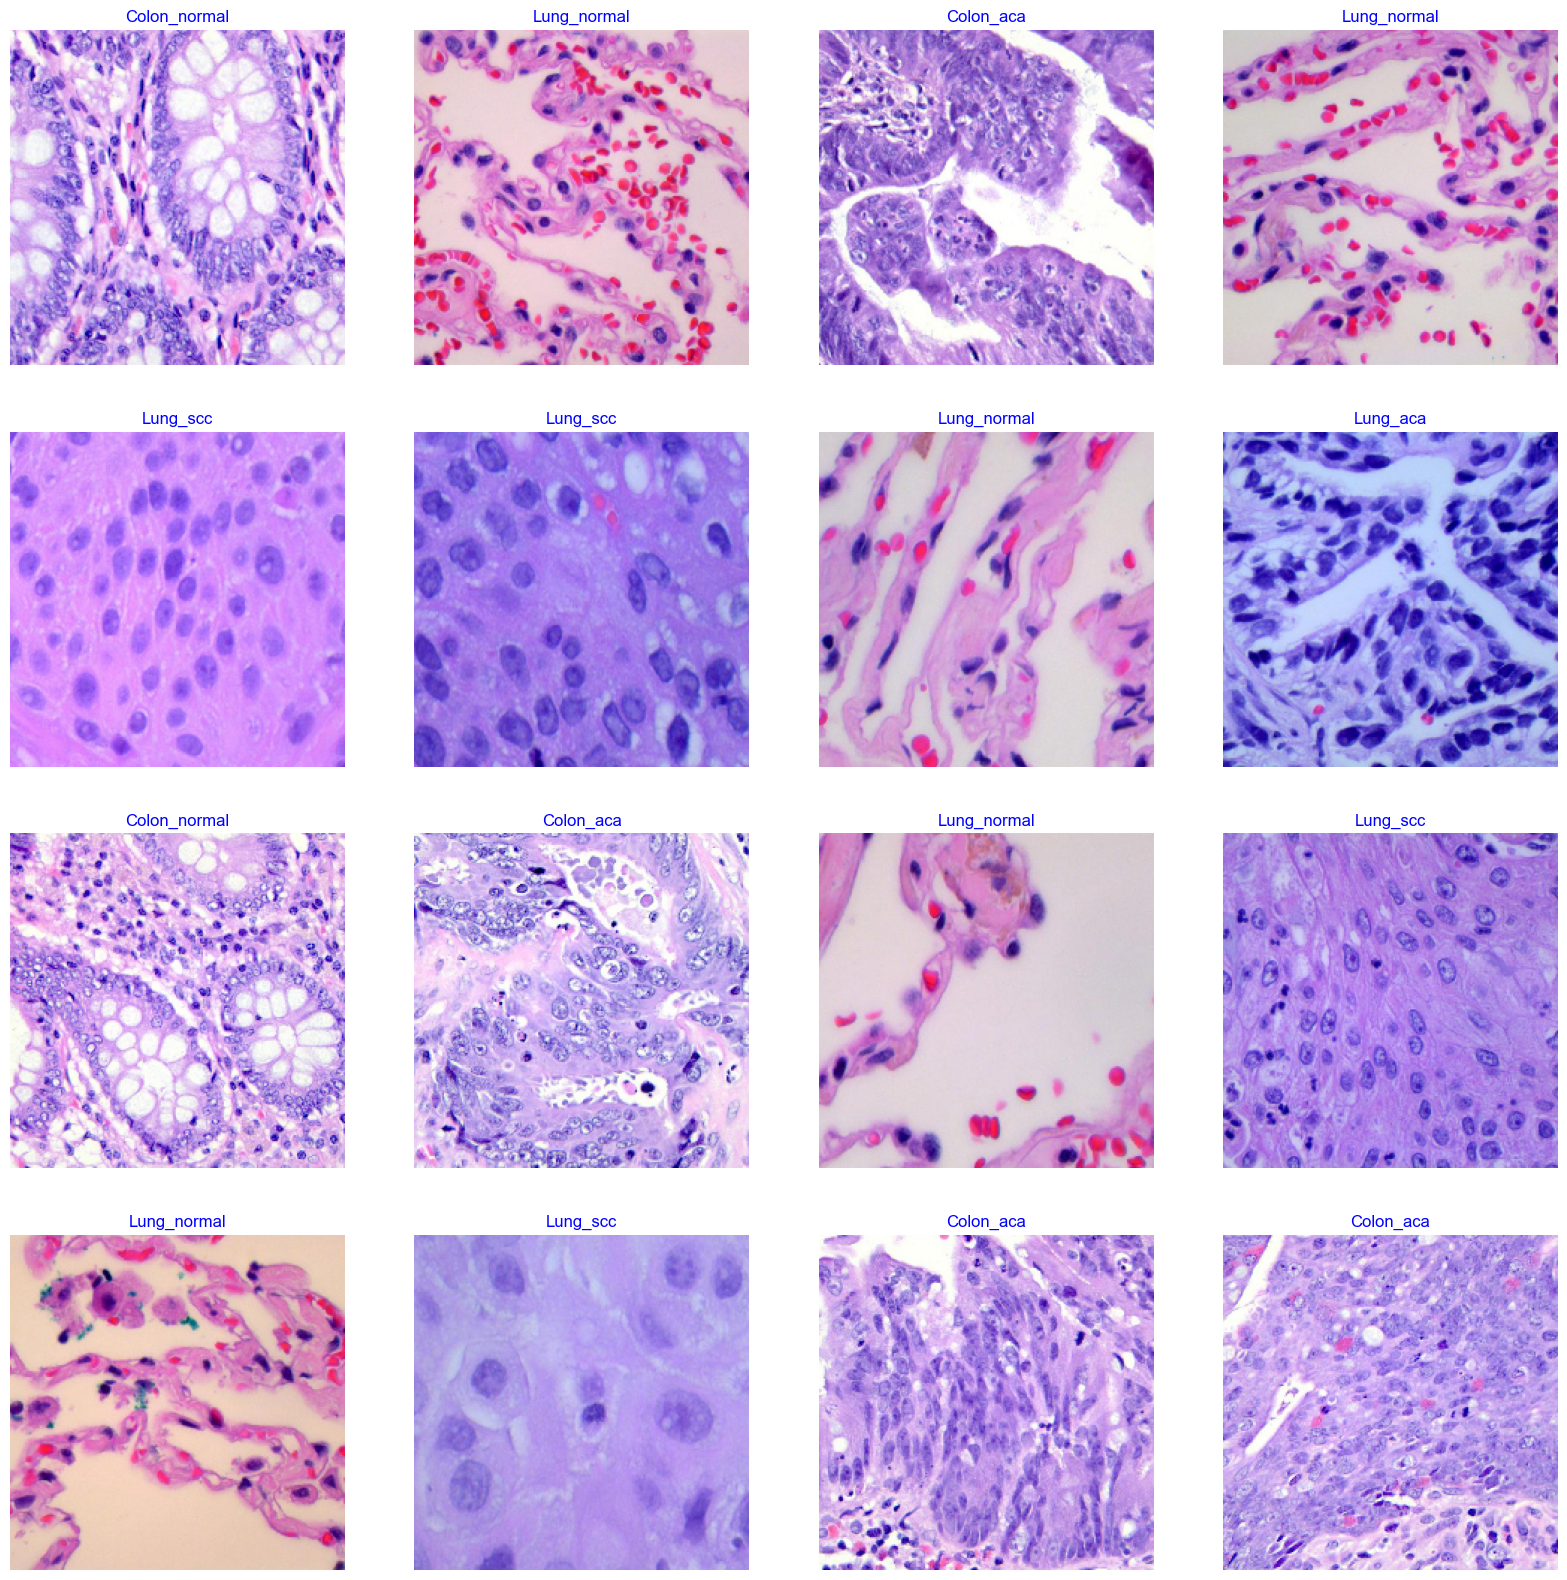

In [9]:
g_dict = train_gen.class_indices  # defines dictionary {'class': index}
classes = list(
    g_dict.keys()
)  # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)  # get a batch size samples from the generator

plt.figure(figsize=(20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255  # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]  # get class of image
    plt.title(class_name, color="blue", fontsize=12)
    plt.axis("off")
plt.show()

In [10]:
class_count = len(list(train_gen.class_indices.keys()))

# define the model
baseModel = MobileNetV2(
    weights="imagenet", include_top=False, input_shape=(224, 224, 3)
)
baseModel.summary()

# construct the head of the model that will be placed on top of the
# the base model (A simple CNN as the Head model)
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="sigmoid")(headModel)
headModel = Dropout(0.25)(headModel)
headModel = Dense(class_count, activation="sigmoid")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [11]:
INIT_LR = 0.01
EPOCHS = 28
# Complie the model and train it
model.compile(loss="categorical_crossentropy", optimizer="RMSprop", metrics=["accuracy"])

print(
    """[INFO] compiling model...
[INFO] training head..."""
)


# train the head of the network
H = model.fit(
    x=train_gen,
    validation_data=valid_gen,
    validation_steps=None,
    epochs=EPOCHS,
    shuffle=False,
    verbose=1,
)

[INFO] compiling model...
[INFO] training head...
Epoch 1/28


2023-08-26 15:54:14.054900: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


138/138 [==============================] - 115s 822ms/step - loss: 0.5820 - accuracy: 0.7689 - val_loss: 0.4777 - val_accuracy: 0.7960
Epoch 2/28
138/138 [==============================] - 112s 811ms/step - loss: 0.3566 - accuracy: 0.8569 - val_loss: 0.3199 - val_accuracy: 0.8705
Epoch 3/28
138/138 [==============================] - 113s 818ms/step - loss: 0.2990 - accuracy: 0.8807 - val_loss: 0.2899 - val_accuracy: 0.8813
Epoch 4/28
138/138 [==============================] - 113s 813ms/step - loss: 0.2734 - accuracy: 0.8896 - val_loss: 0.2943 - val_accuracy: 0.8783
Epoch 5/28
138/138 [==============================] - 114s 820ms/step - loss: 0.2492 - accuracy: 0.8997 - val_loss: 0.2650 - val_accuracy: 0.8982
Epoch 6/28
138/138 [==============================] - 115s 830ms/step - loss: 0.2393 - accuracy: 0.9017 - val_loss: 0.2607 - val_accuracy: 0.8956
Epoch 7/28
138/138 [==============================] - 115s 833ms/step - loss: 0.2229 - accuracy: 0.9084 - val_loss: 0.2372 - val_accura

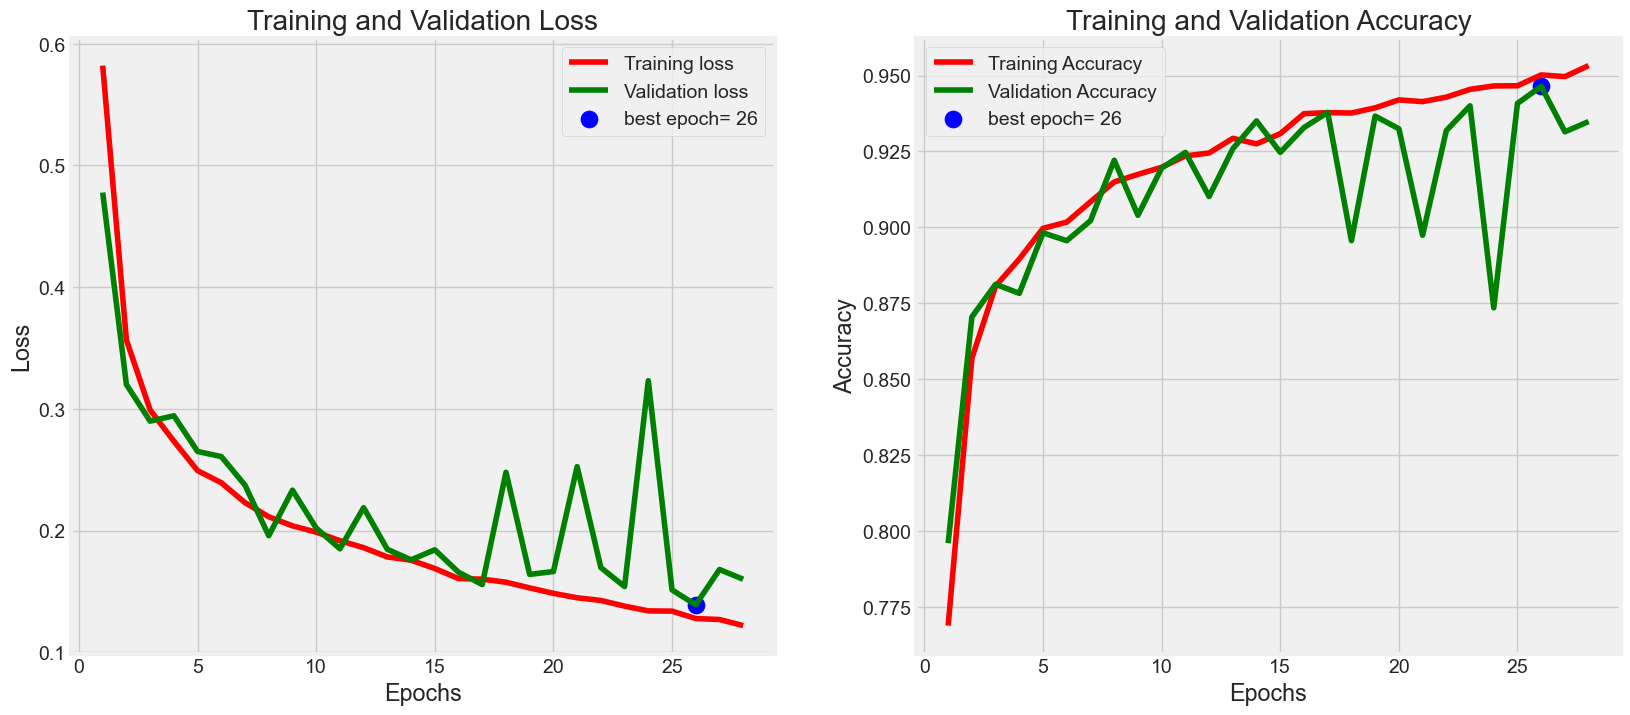

In [12]:
tr_acc = H.history["accuracy"]
tr_loss = H.history["loss"]
val_acc = H.history["val_accuracy"]
val_loss = H.history["val_loss"]
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f"best epoch= {str(index_loss + 1)}"
acc_label = f"best epoch= {str(index_acc + 1)}"

# Plot training history
plt.figure(figsize=(20, 8))
plt.style.use("fivethirtyeight")

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, "r", label="Training loss")
plt.plot(Epochs, val_loss, "g", label="Validation loss")
plt.scatter(index_loss + 1, val_lowest, s=150, c="blue", label=loss_label)
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, "r", label="Training Accuracy")
plt.plot(Epochs, val_acc, "g", label="Validation Accuracy")
plt.scatter(index_acc + 1, acc_highest, s=150, c="blue", label=acc_label)
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout
plt.show()

In [13]:
ts_length = len(test_df)
test_batch_size = max(
    sorted(
        [
            ts_length // n
            for n in range(1, ts_length + 1)
            if ts_length % n == 0 and ts_length / n <= 80
        ]
    )
)
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps=test_steps, verbose=1)
valid_score = model.evaluate(valid_gen, steps=test_steps, verbose=1)
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print("-" * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print("-" * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

37/37 [==============================] - 14s 354ms/step - loss: 0.1572 - accuracy: 0.9408
Train Loss:  0.11409259587526321
Train Accuracy:  0.9533361196517944
--------------------
Validation Loss:  0.15708115696907043
Validation Accuracy:  0.9360219836235046
--------------------
Test Loss:  0.15723763406276703
Test Accuracy:  0.9408075213432312


In [14]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)


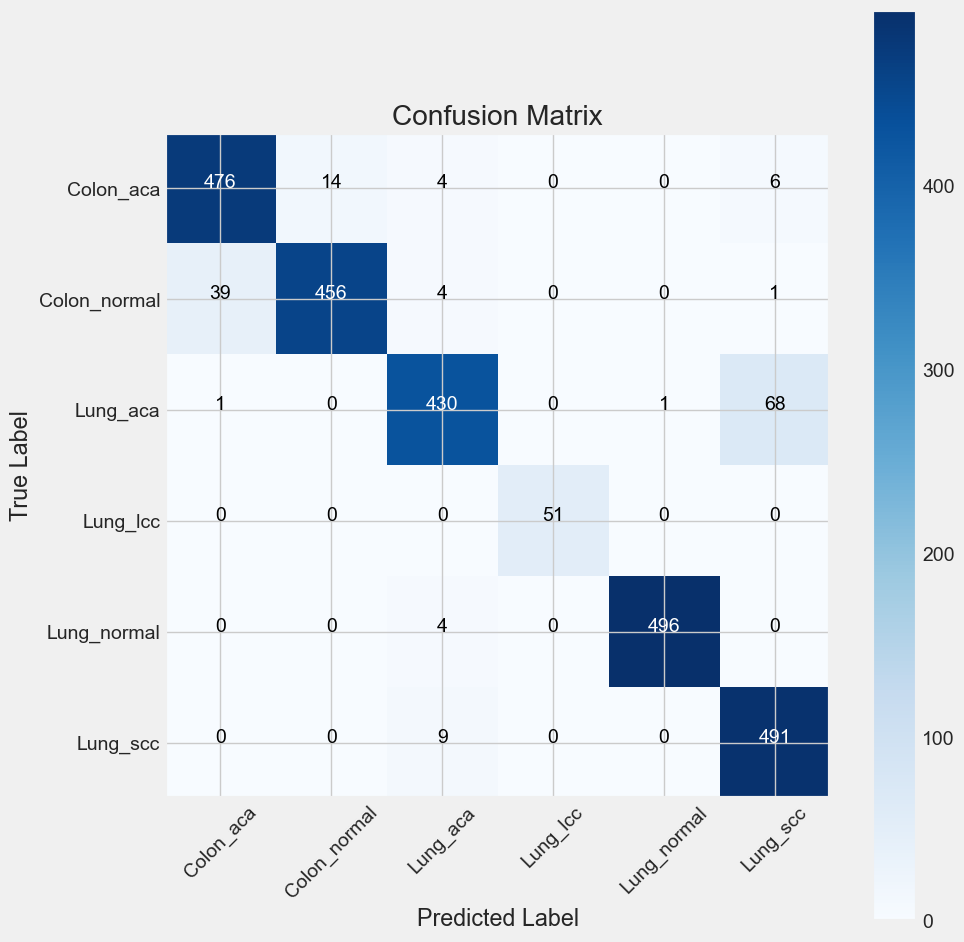

In [15]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j,
        i,
        cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True Label")
plt.xlabel("Predicted Label")

plt.show()

In [16]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names=classes))

              precision    recall  f1-score   support

   Colon_aca       0.92      0.95      0.94       500
Colon_normal       0.97      0.91      0.94       500
    Lung_aca       0.95      0.86      0.90       500
    Lung_lcc       1.00      1.00      1.00        51
 Lung_normal       1.00      0.99      0.99       500
    Lung_scc       0.87      0.98      0.92       500

    accuracy                           0.94      2551
   macro avg       0.95      0.95      0.95      2551
weighted avg       0.94      0.94      0.94      2551



In [17]:
model.save("Lung_Colon_Cancer1.h5")

In [18]:
loaded_model = tf.keras.models.load_model("./Lung_Colon_Cancer.h5", compile=False)
loaded_model.compile(
    Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"]
)

In [19]:
image_path = "./Lung_Colon_Dataset/Test/Lung_scc/lungscc4501.jpeg"
image = Image.open(image_path)
# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = [
    "Colon_aca",
    "Colon_normal",
    "Lung_aca",
    "Lung_lcc",
    "Lung_normal",
    "Lung_scc",
]
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 1s 742ms/step
Lung_scc
